# Introductıon
The goal of this analysis is to develop a suitable machine learning model which can estimate death risk and potential causes using medical data from [COVID-19 Dataset](https://www.kaggle.com/datasets/meirnizri/covid19-dataset) provided by the Mexican government.

### Notebook Contents:
* [Data Importing](#section1)    
* [Data Preprocessing and Visualization](#section2)
* [Feature Engineering](#section3)
* [Model Training](#section4)
* [Model Analysis](#section5)
* [Conclusion](#section6)

<a id='section1'></a>
# Data Importing

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
#from keras.layers import Dropout
#from keras.regularizers import l1, l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

**Dataset** contains an enormous number of anonymized patient-related information including pre-conditions. 
The raw dataset consists of 21 unique features and unique patients. 
**In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.**

* sex: 1 for female and 2 for male.
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid.
* patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.

### **Overview Dataset**

In [108]:
pd.set_option('display.max_columns', None)
df = pd.read_csv("datasets/Covid Data.csv.zip", low_memory = False)
print("Dataset Shape :",df.shape)
df.head()

Dataset Shape : (1048575, 21)


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,2,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,2,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,2,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,2,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,2,2,2,1,2,2,2,2,2,3,97


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

<a id='section2'></a>
# Data Preprocessing and Visualization

### DATE_DIED feature

* **DATE_DIED** column has value "9999-99-99" for alive person so we take this feature to track alive or dead patient. 
* Make new column '**DEATH**' where 1 means dead and 0 means alive. Drop '**DATE_DIED**' column from the dataset

In [110]:
# if we have "9999-99-99" value then it means the patient is alive

df['DEATH'] = df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1)

# drop DATE_DIED column
df.drop(columns=["DATE_DIED"], inplace=True)

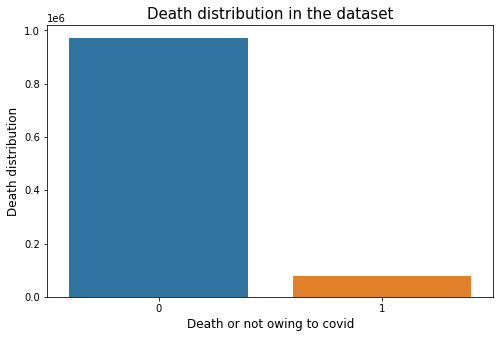

In [111]:
death_dist = df.DEATH.value_counts()
plt.figure(figsize = (8,5))
sns.barplot(x = death_dist.index, y = death_dist.values)
plt.xlabel('Death or not owing to covid', fontsize = 12)
plt.ylabel('Death distribution', fontsize = 12)
plt.title('Death distribution in the dataset', fontsize = 15)
plt.show()

* Death and alive case do not have even distribution.

### Feature-Death Bar Plot
* Make dataset features and death barplot to observe the impact of features on 
patient death and feature missing values.

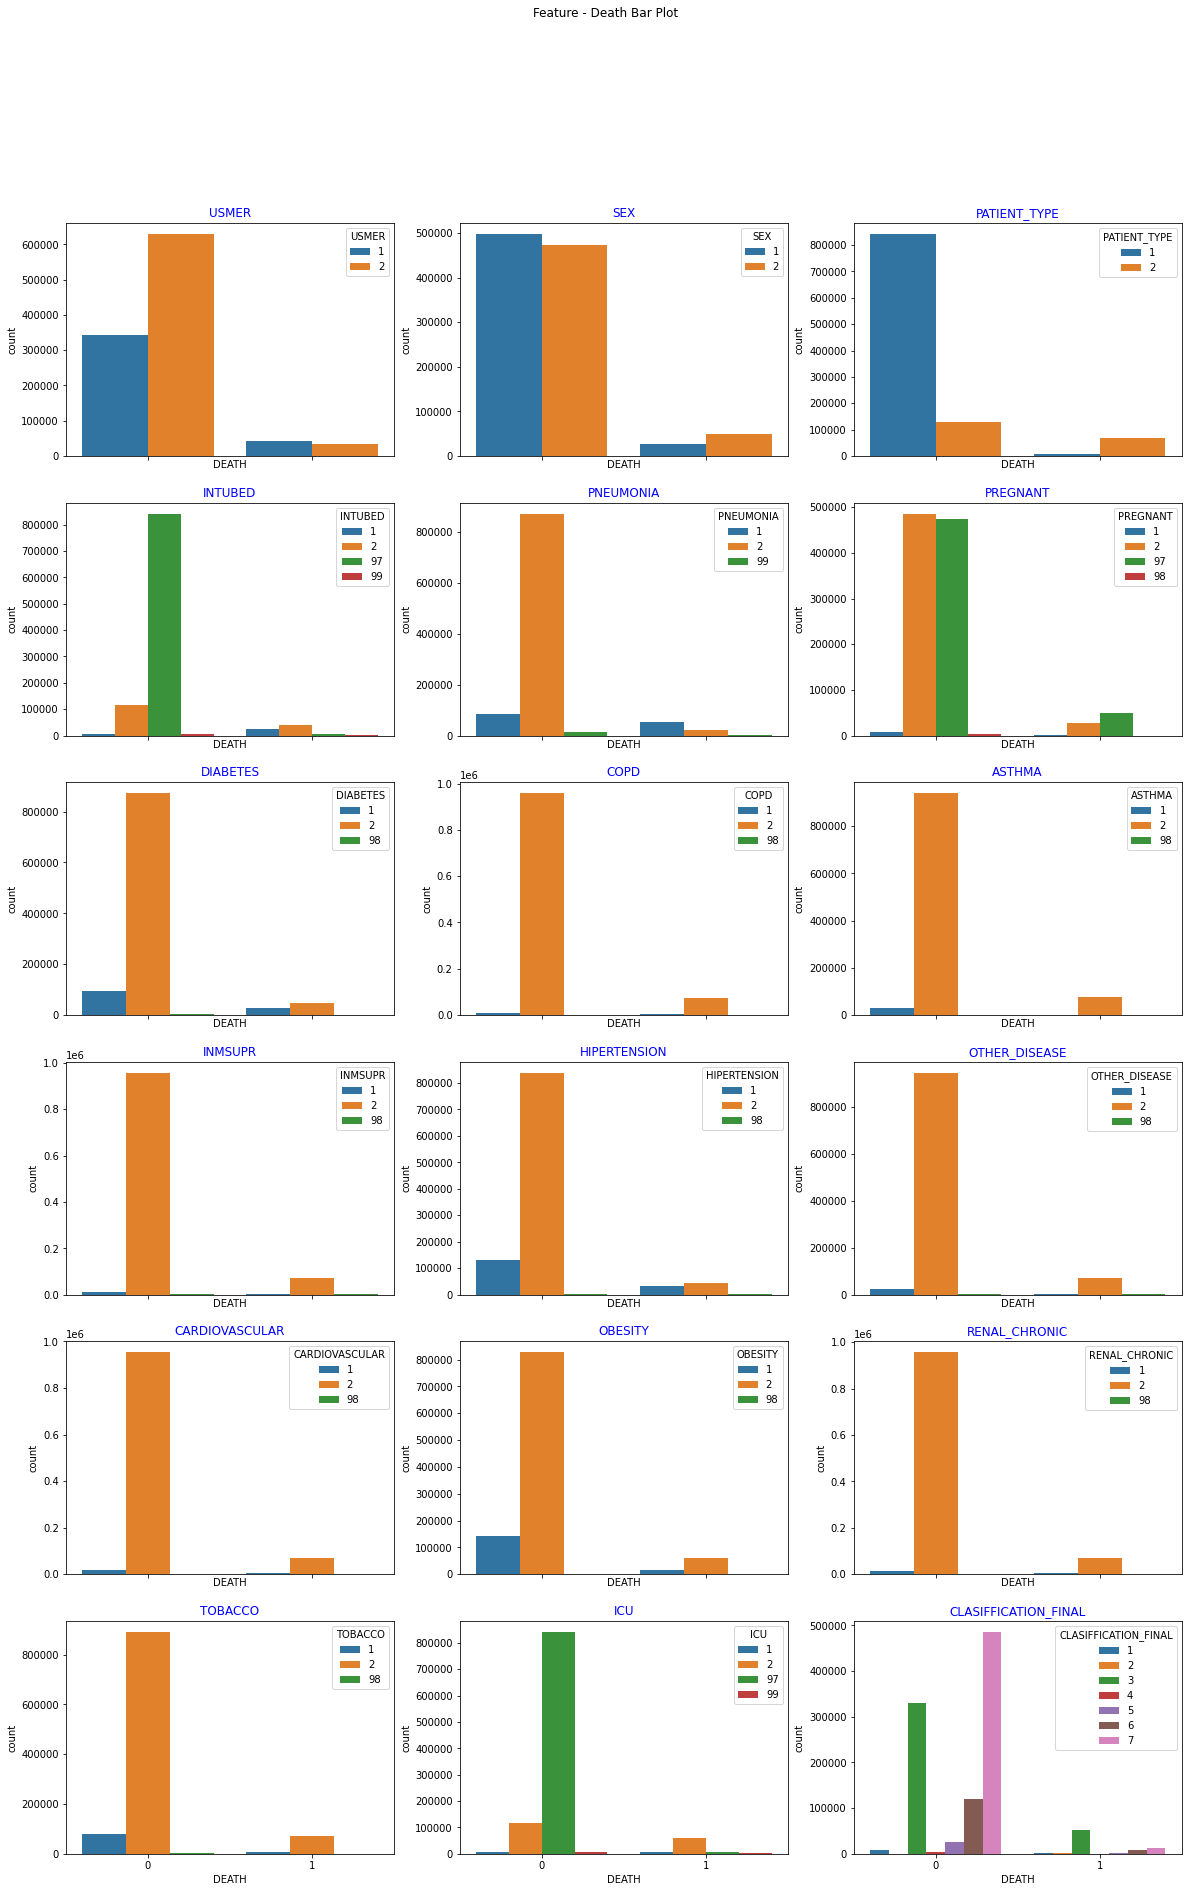

In [112]:
features_list = ["USMER","SEX","PATIENT_TYPE","INTUBED","PNEUMONIA","PREGNANT","DIABETES","COPD","ASTHMA","INMSUPR","HIPERTENSION","OTHER_DISEASE","CARDIOVASCULAR","OBESITY","RENAL_CHRONIC","TOBACCO","ICU", "CLASIFFICATION_FINAL"]

fig,axes = plt.subplots(6,3,sharex=True,figsize=(20,30))
fig.suptitle("Feature - Death Bar Plot")

a=0
b=0
for feature in features_list: 
    sns.countplot(x='DEATH', hue = feature, data=df, ax=axes[a][b])
    axes[a][b].set_title(feature,color="blue")
    b+=1
    if b>2:
        a+=1
        b=0
fig.show()

* More male died compared to female but overall, **SEX** feature had very little impact on covid deaths, so we can drop it.
* **INTUBED**, **ICU** and **PREGNANT** feature has too many missing values and so we can drop the columns.

In [113]:
# drop SEX, INTUBED, ICU and PREGNANT columns

df.drop(columns=["SEX","INTUBED","ICU","PREGNANT"],inplace=True)

* **CLASIFFICATION_FINAL** feature represents covid test results. Values 1-3 mean 
that the patient was diagnosed with covid in different degrees. 4 or higher means that the patient is not a carrier of covid.

* So we can create new feature **INFECTED** from **CLASIFFICATION_FINAL** feature where 1 means infected by covid and 0 otherwise. Then we drop **CLASIFFICATION_FINAL** column.

In [114]:
df["INFECTED"] = df.CLASIFFICATION_FINAL.apply(lambda x: 1 if x < 4 else 0)

df.drop(columns=["CLASIFFICATION_FINAL"],inplace=True)

### Age-Death Distribution

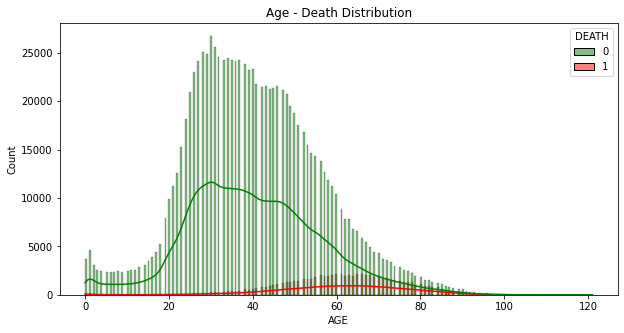

In [115]:
plt.figure(figsize=(10,5))
sns.histplot(x=df.AGE,hue=df.DEATH,legend=True,palette=["green","red"],kde=True).set(title="Age - Death Distribution")
plt.show()

* Patients are roughly between 20-60 years old.
* The older patients are more likely to die compared to younger ones.

### Feature Correlations

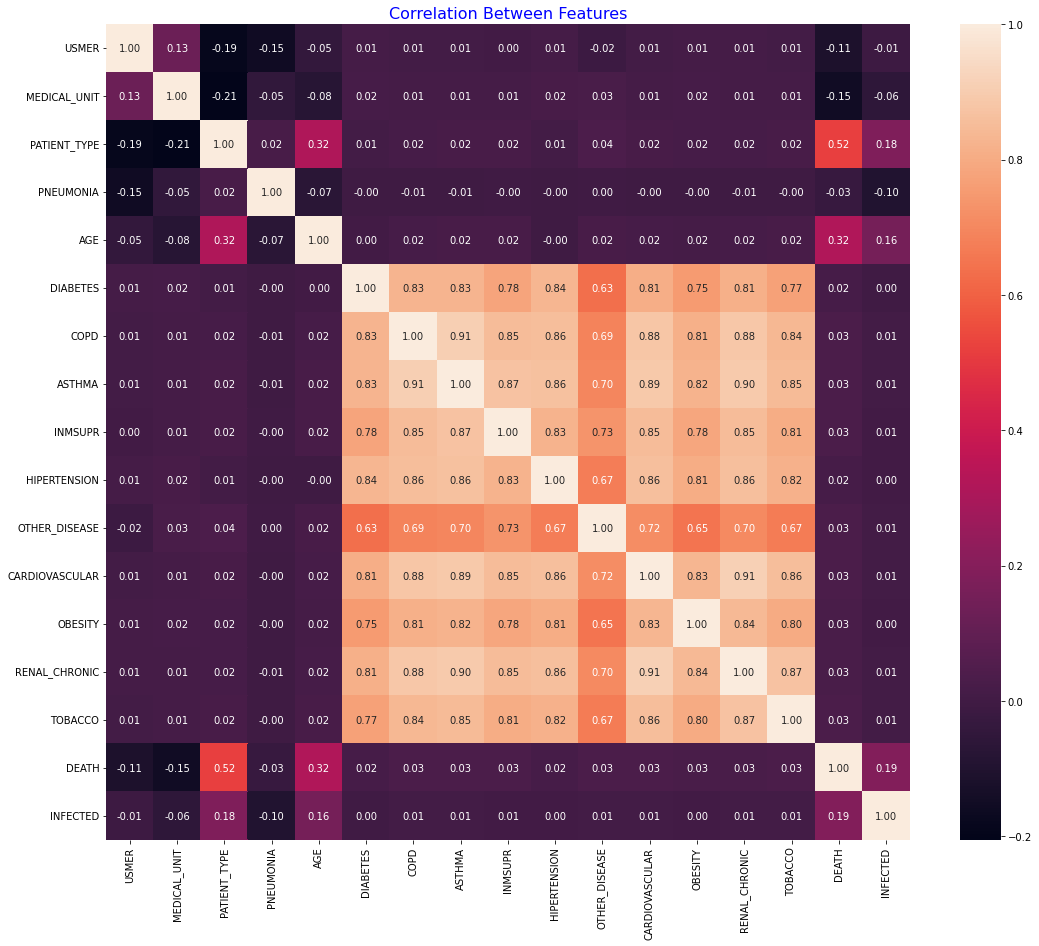

In [116]:
plt.figure(figsize=(18,15))
sns.heatmap(df.corr(),annot=True, fmt=".2f")
plt.title("Correlation Between Features",fontsize=16,color="blue");

<a id='section3'></a>
# Feature Engineering

### Drop Low Correlation Features

**COPD, ASTHMA, INMSUPR, OTHER_DISEASE, CARDIOVASCULAR, OBESITY, RENAL_CHRONIC, TOBACCO** features has lower correlations and so we can drop these columns.

In [117]:
drop_columns = ["COPD","ASTHMA","INMSUPR","OTHER_DISEASE","CARDIOVASCULAR","OBESITY","RENAL_CHRONIC","TOBACCO"]

df.drop(columns=drop_columns,inplace=True)

In [118]:
df.head()

,USMER,MEDICAL_UNIT,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,HIPERTENSION,DEATH,INFECTED
0,2,1,1,1,65,2,1,1,1
1,2,1,1,1,72,2,1,1,0
2,2,1,2,2,55,1,2,1,1
3,2,1,1,2,53,2,2,1,0
4,2,1,1,2,68,1,1,1,1


### Drop Missing Values

Drop missing values in **PNEUMONIA**, **DIABETES** and **HIPERTENSION** features.


In [119]:
df = df[(df.PNEUMONIA == 1) | (df.PNEUMONIA == 2)]
df = df[(df.DIABETES == 1) | (df.DIABETES == 2)]
df = df[(df.HIPERTENSION == 1) | (df.HIPERTENSION == 2)]

### One Hot Encoding
Convert data into One Hot Encoded feature except "**MEDICAL_UNIT**", "**AGE**", "**DEATH**" and "**INFECTED**" feature.

In [120]:
df.USMER = df.USMER.apply(lambda x: x if x == 1 else 0)                     
df.PATIENT_TYPE = df.PATIENT_TYPE.apply(lambda x: 0 if x == 1 else 1)     
df.PNEUMONIA = df.PNEUMONIA.apply(lambda x: x if x == 1 else 0)           
df.DIABETES = df.DIABETES.apply(lambda x: x if x == 1 else 0)             
df.HIPERTENSION = df.HIPERTENSION.apply(lambda x: x if x == 1 else 0)     

### Scaling Numeric Features

**MEDICAL_UNIT** and **AGE** feature has numeric values and so we normalize them.

In [121]:
scaler = RobustScaler()
df.AGE = scaler.fit_transform(df.AGE.values.reshape(-1,1))
df.MEDICAL_UNIT = scaler.fit_transform(df.MEDICAL_UNIT.values.reshape(-1,1))

### Modified DataSet

In [122]:
df.head()

,USMER,MEDICAL_UNIT,PATIENT_TYPE,PNEUMONIA,AGE,DIABETES,HIPERTENSION,DEATH,INFECTED
0,0,-1.375,0,1,1.086957,0,1,1,1
1,0,-1.375,0,1,1.391304,0,1,1,0
2,0,-1.375,1,0,0.652174,1,0,1,1
3,0,-1.375,0,0,0.565217,0,0,1,0
4,0,-1.375,0,0,1.217391,1,1,1,1


<a id='section4'></a>
# Model Training

### Input and Output Data

Model input data contains all features except **DEATH** and output data is only 
**DEATH** feature.

In [123]:
input = df.drop(columns="DEATH")
output = df["DEATH"]

### Training Data Distribution

Split original input and output data into train and test set in 9 : 1 ratio.

In [124]:
def split_data(input, output, test_percentage=0.1):

  # split data in to train and test set test_percentage ratio
  train_x, test_x, train_y, test_y = train_test_split(input,output, test_size=test_percentage, shuffle=True)

  # convert train and test frame in to numpy
  train_x = train_x.to_numpy()
  train_y = train_y.to_numpy()
  train_y = np.reshape(train_y, (len(train_y), 1))

  test_x = test_x.to_numpy()
  test_y = test_y.to_numpy()
  test_y = np.reshape(test_y, (len(test_y), 1))

  return train_x, train_y, test_x, test_y


In [125]:
train_x, train_y, test_x, test_y = split_data(input,output)

print("train_x :",train_x.shape)
print("test_x :",test_x.shape)
print("train_y :",train_y.shape)
print("test_y :",test_y.shape)

train_x : (925961, 8)
test_x : (102885, 8)
train_y : (925961, 1)
test_y : (102885, 1)


### Logistic Regression Model

We perform Logistic Regression for COVID-19 Death Prediction using Keras Sequence Model. 
Model contains 3 Dense layers with [128, 64, 32] units and RELU activation and 1 unit Dense layer with Sigmoid activation.

* Batch Size = 512
* Learning Rate = 0.01
* Optimization Algo = Adam
* Loss = Binary Crossentropy

In [126]:
def model_training(train_x,train_y, epochs=10, batch_size=512, learning_rate=0.01):

  # Define Optimization Algo
  optimizer = Adam(learning_rate = learning_rate)

  # Define Model

  model = Sequential()
  model.add(Dense(128, input_dim = train_x.shape[1], activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))

  # Compile Model
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

  # Train Model
  history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size)

  return model, history

In [127]:
logit_model, logit_history = model_training(train_x,train_y)

Epoch 1/10
1809/1809 [==============================] - 12s 6ms/step - loss: 0.1317 - accuracy: 0.9370
Epoch 2/10
1809/1809 [==============================] - 10s 6ms/step - loss: 0.1290 - accuracy: 0.9378
Epoch 3/10
1809/1809 [==============================] - 10s 5ms/step - loss: 0.1281 - accuracy: 0.9383
Epoch 4/10
1809/1809 [==============================] - 11s 6ms/step - loss: 0.1277 - accuracy: 0.9388
Epoch 5/10
1809/1809 [==============================] - 11s 6ms/step - loss: 0.1275 - accuracy: 0.9387
Epoch 6/10
1809/1809 [==============================] - 13s 7ms/step - loss: 0.1272 - accuracy: 0.9387
Epoch 7/10
1809/1809 [==============================] - 11s 6ms/step - loss: 0.1271 - accuracy: 0.9386
Epoch 8/10
1809/1809 [==============================] - 11s 6ms/step - loss: 0.1270 - accuracy: 0.9387
Epoch 9/10
1809/1809 [==============================] - 10s 6ms/step - loss: 0.1268 - accuracy: 0.9389
Epoch 10/10
1809/1809 [==============================] - 9s 5ms/step - lo

### Model Evaluation Metrics

In [128]:
def model_evaluation_metrics(model,test_x,test_y, threashold=0.5):

  # predict value and classes for test_x input data using given model
  test_y_Hprobs = model.predict(test_x, verbose=0)
  test_y_Hclasses = (test_y_Hprobs >= threashold).astype("int32") 
  test_y_Hprobs = test_y_Hprobs[:,0]

  # model accuracy for test dataset
  accuracy = accuracy_score(test_y, test_y_Hclasses)

  # model precision for test dataset
  precision = precision_score(test_y, test_y_Hclasses)

  # model precision for test dataset
  recall = recall_score(test_y, test_y_Hclasses)

  # model f1__score for test dataset
  f1score = f1_score(test_y, test_y_Hclasses)

  # model confusion_matrix for test dataset
  confusion_mat = confusion_matrix(test_y, test_y_Hclasses)

  return test_y_Hprobs, test_y_Hclasses, accuracy, precision, recall, f1score, confusion_mat

In [129]:
_, _, accuracy, precision, recall, f1score, confusion_mat = model_evaluation_metrics(logit_model,test_x,test_y)

evaluation_df = pd.DataFrame(columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1Score'])
evaluation_df = evaluation_df.append({'Model' : 'LR Model','Accuracy' : accuracy, 'Precision' : precision, 'Recall' : recall, 'F1Score': f1score},ignore_index = True)
evaluation_df.head()

,Model,Accuracy,Precision,Recall,F1Score
0,LR Model,0.938971,0.638825,0.369167,0.467926


### Model Confusion Matrix

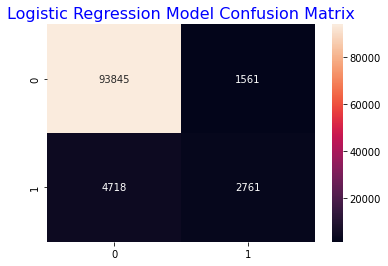

In [130]:
sns.heatmap(confusion_mat, annot=True, fmt=".0f")
plt.title("Logistic Regression Model Confusion Matrix",fontsize=16, color="blue");

<a id='section5'></a>
# Model Analysis

* Logistic Regression Model achieved 93% test accuracy
* F1 Score is 47 which means we predicted the patients who survived well but we can't say the same thing for dead patients. 
* We also get the same picture from confusion matrix which shows more false positive result than true positive. 
* This problem can be based on imbalanced dataset.

### Death Distribution

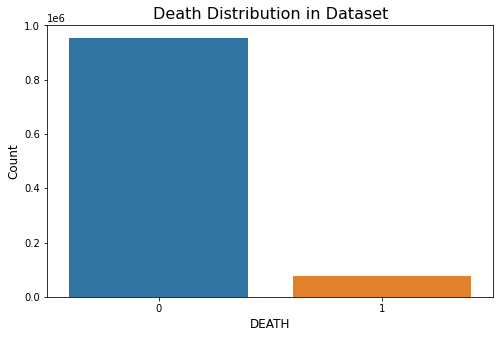

In [131]:
death_dist = df.DEATH.value_counts()
plt.figure(figsize = (8,5))
sns.barplot(x = death_dist.index, y = death_dist.values)
plt.xlabel('DEATH', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Death Distribution in Dataset', fontsize = 16)
plt.show()

### Data Undersampling
Too many patients are alive compared to number of dead patients in the dataset.
We can undersample data in order to keep all dead patient records while shrinking alive patient records randomly. 

In [132]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
input_under_sampled,output_under_sampled = rus.fit_resample(input,output)

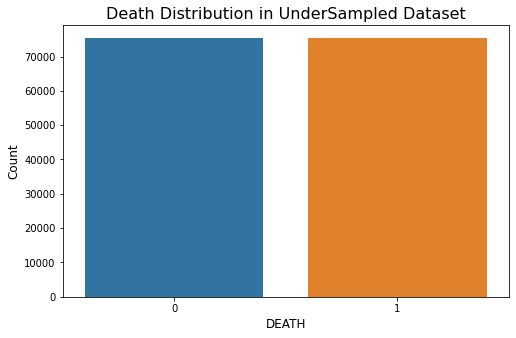

In [133]:
death_dist = output_under_sampled.value_counts()
plt.figure(figsize = (8,5))
sns.barplot(x = death_dist.index, y = death_dist.values)
plt.xlabel('DEATH', fontsize = 12)
plt.ylabel('Count', fontsize = 12)
plt.title('Death Distribution in UnderSampled Dataset', fontsize = 16)
plt.show()

### Train and Evaluate Logistic Regression Model with UnderSampled data

In [134]:
utrain_x, utrain_y, utest_x, utest_y = split_data(input_under_sampled,output_under_sampled)

print("utrain_x :",utrain_x.shape)
print("utest_x :",utest_x.shape)
print("utrain_y :",utrain_y.shape)
print("utest_y :",utest_y.shape)

ulogit_model, ulogit_history = model_training(utrain_x,utrain_y)

_, _, uaccuracy, uprecision, urecall, uf1score, uconfusion_mat = model_evaluation_metrics(ulogit_model,utest_x,utest_y)

evaluation_df = evaluation_df.append({'Model': 'LR Model Under Sampled','Accuracy' : uaccuracy, 'Precision' : uprecision, 'Recall' : urecall, 'F1Score': uf1score},ignore_index = True)
evaluation_df.head()

utrain_x : (135730, 8)
utest_x : (15082, 8)
utrain_y : (135730, 1)
utest_y : (15082, 1)
Epoch 1/10
266/266 [==============================] - 2s 5ms/step - loss: 0.2606 - accuracy: 0.9046
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2485 - accuracy: 0.9101
Epoch 3/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2471 - accuracy: 0.9105
Epoch 4/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2452 - accuracy: 0.9110
Epoch 5/10
266/266 [==============================] - 2s 6ms/step - loss: 0.2444 - accuracy: 0.9112
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2452 - accuracy: 0.9110
Epoch 7/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2443 - accuracy: 0.9113
Epoch 8/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2440 - accuracy: 0.9112
Epoch 9/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2434 - accuracy: 0.9117
Epoch 10/10


,Model,Accuracy,Precision,Recall,F1Score
0,LR Model,0.938971,0.638825,0.369167,0.467926
1,LR Model Under Sampled,0.910423,0.882462,0.947661,0.913900


### Model Confusion Matrix

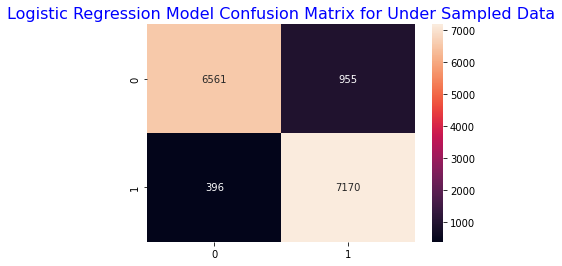

In [135]:
sns.heatmap(uconfusion_mat, annot=True, fmt=".0f")
plt.title("Logistic Regression Model Confusion Matrix for Under Sampled Data",fontsize=16, color="blue");

### Model Comparison

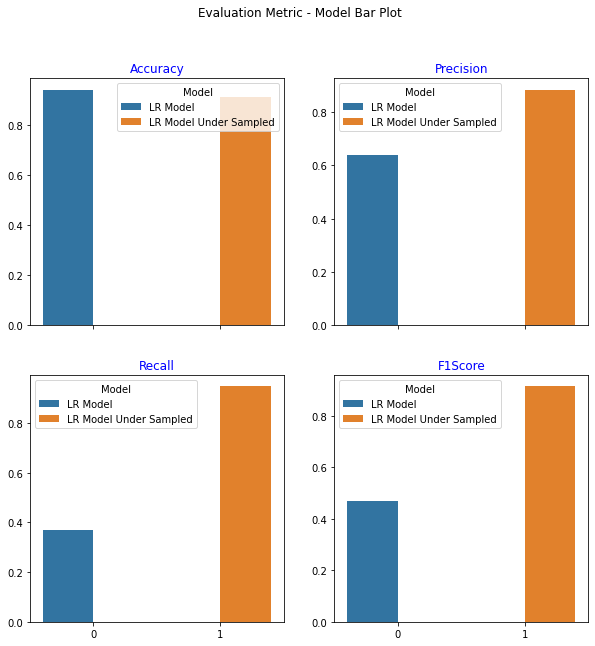

In [136]:
model_list = evaluation_df.Model.to_list()
evaluation_df.drop(columns=["Model"],inplace=True)
metric_list = evaluation_df.columns.to_list()

fig,axes = plt.subplots(2,2,sharex=True,figsize=(10,10))
fig.suptitle("Evaluation Metric - Model Bar Plot")

a=0
b=0
for metric in metric_list: 
    sns.barplot(x=evaluation_df[metric].index, y=evaluation_df[metric].values,hue=evaluation_df[metric].index, ax=axes[a][b])
    axes[a][b].set_title(metric,color='blue')
    legnd_handles, _ = axes[a][b].get_legend_handles_labels()
    axes[a][b].legend(legnd_handles, model_list, title="Model")
    b+=1
    if b>1:
        a+=1
        b=0
fig.show()

* F1 Score became 91 from 47 after Under Sampling.
* Also Pression and Recall is higher in Under Sampled Model.

### Logistic Regression Model ROC Curve

472/472 [==============================] - 1s 2ms/step


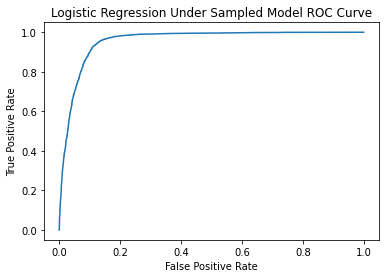

In [137]:
# predict under sampled data model for test set 
utest_yHprob = ulogit_model.predict(utest_x)

#plot ROC Curve
ufpr, utpr, uthresholds = roc_curve(utest_y, utest_yHprob[:,0])
plt.plot(ufpr, utpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression Under Sampled Model ROC Curve")
plt.show()



<a id='section6'></a>
# Conclusion

* Successfully developed COVID-19 death prediction model with 93% accuracy and 0.91 F1 Score using Logistic Regression.
* Data Under Sampled to balance covid death and alive case ratio which increased Precision and F1 Score.